## Preprocessing Data

**Data pre-processing techniques** generally refer to the addition, deletion, or transformation of training set data. **Feature extraction**, is one empirical technique for creating surrogate variables that are combinations of multiple predictors. Additionally, simpler strategies such as removing predictors based on their lack of information content can also be effective. 

How the predictors are encoded, called **feature engineering**, can have a significant impact on model performance. The 'correct' feature engineering depends on several factors. 

- First, some encodings may be optimal for some models and poor for others. For instance, trees will partition data into bins anyways, so scaling does not have an impact.
- Also, in some models, multiple encodings of the same data may cause problems. For instance, in creating one-hot or dummy variables, if not careful, can cause multi-colinearity in [linear regression models](../supervised_learning/linear_regression.ipynb).
- The relationship between the predictor and the outcome is also a factor. Many of the data preprocessing techniques are 'unsupervised' in that the label are not taken into account. The [PLS technique](../supervised_learning/linear_regression.ipynb) is probably one exception.

### `sklearn`'s objects

Since we will be talking about estimators and transformers a lot in below, it is beneficial to talk about these concepts

- **Estimators**

Any object that can estimate some parameters based on a dataset is called an estimator (e.g., an imputer is an estimator). The estimation itself is performed by the `fit()` method, and it takes only a dataset as a parameter (or two for supervised learning algorithms; the second dataset contains the labels). Any other parameter needed to guide the estimation process is considered a hyperparameter (such as an imputer’s strategy), and it must be set as an instance variable (generally via a constructor parameter).

- **Transformers**

Some estimators (such as an imputer) can also transform a dataset; these are called transformers. Once again, the API is simple: the transformation is performed by the `transform()` method with the dataset to transform as a parameter. It returns the transformed dataset. This transformation generally relies on the learned parameters, as is the case for an imputer. All transformers also have a convenience method called `fit_transform()` that is **equivalent to calling `fit()` and then `transform()`** (but sometimes `fit_transform()` is optimized and runs much faster).

- **Predictors**

Finally, some estimators, given a dataset, are capable of making predictions; they are
called predictors. For example, the `LinearRegression` model was a predictor. A predictor has a `predict()` method that takes a dataset of new instances and returns a dataset of corresponding predictions. It also has a `score()` method that measures the quality of the predictions, given a test set (and the corresponding labels, in the case of supervised learning algorithms).

### Standardization, or mean removal and variance scaling

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation. They might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

Many elements used in the objective function of a learning algorithm assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. 
- For instance, the RBF kernel of [SVM](../supervised_learning/svm.ipynb)
- The l1 and l2 [regularizers of linear models](../supervised_learning/linear_regression.ipynb) is also sensitive the feature scales
- For unsupervised learning algorithms, [PCA](../unsupervised_learning/PCA.ipynb) is also sensitive to standardization.
- A notable exception is perhaps [CART](../supervised_learning/CART.ipynb) and other tree-based models.

#### `StandardScaler`

The `preprocessing` module further provides a utility class `StandardScaler` that implements the `Transformer` API to compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set - this is important or otherwise we risk generating training-serving skews. This class is hence suitable for use in the early steps of a `sklearn.pipeline.Pipeline`.

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train)

#scaler.mean_
#scaler.scale_

scaler.transform(X_train)
scaler.transform(X_test)

It is possible to disable either centering or scaling by either passing `with_mean=False` or `with_std=False` to the constructor of StandardScaler.

#### `MinMaxScaler` and `MaxAbsScaler`

An alternative standardization is scaling features to lie between a given minimum and maximum value, often $[0, 1]$, or $[-1, 1]$. The motivation to use this scaling include robustness to very small standard deviations of features and preserving zero entries in sparse data.

Centering sparse data would destroy the sparseness structure in the data, and thus rarely is a sensible thing to do. However, it can make sense to scale sparse inputs, especially if features are on different scales. In those cases, `MaxAbsScaler` can be the choice.

The `StandardScaler` and `MinMaxScaler` sometimes yield similar results, but there are also cases where the results are drastically different. The difference is probably attributed to the fact that `StandardScaler` does not yield bounded output while `MinMaxScaler` does. 

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(min, max))
max_abs_scaler = preprocessing.MaxAbsScaler()

#### `RobustScaler` -  dealing with outliers

There are several things to note about outliers before talking about scaling.
- When one or more samples are suspected to be outliers, the first step is to make sure that the values are scientifically valid (e.g., positive blood pressure) and that no data recording errors have occurred.
- Also, the outlying data may be an indication of a special part of the population under study that is just starting to be sampled.
- Note that there are also several predictive models that are resistant to outliers, such as tree-based models and SVMs.

If your data contains many outliers, scaling using the mean and variance of the data is likely to not work very well. In these cases, you can use `RobustScaler` as drop-in replacements instead. They use more robust estimates for the center and range of your data.

#### `KernelCenterer`

If you have a kernel matrix of a kernel  that computes a dot product in a feature space defined by function , a `KernelCenterer` can transform the kernel matrix so that it contains inner products in the feature space defined by  followed by removal of the mean in that space.

### Non-linear transformation

Two types of transformations are available: quantile transforms and power transforms. Both quantile and power transforms are based on monotonic transformations of the features and thus preserve the rank of the values along each feature.
- **Quantile transforms** put all features into the same desired distribution based on the formula $G^{-1}(F(X))$ where $F$ is the cumulative distribution function of the feature and $G^{-1}$ the quantile function of the desired output distribution $G$.
- **Power transforms** are a family of parametric transformations that aim to map data from any distribution to as close to a Gaussian distribution. `PowerTransformer` currently provides two such power transformations, the **Yeo-Johnson transform** and the **Box-Cox transform**, where **Box-Cox is only applicable to positive data only**.

One important reason for non-linear transformation is to **remove distributional skewness**, if that is desired of a feature. A general rule of thumb to consider is that skewed data whose ratio of the highest value to the lowest value is greater than 20 have significant skewness, or one can look at the formal statistic of skewness.

Besides the quantile transform and power transform above, some simpler non-linear transformation include log, square root or inverse.

In [ ]:
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
preprocessing.PowerTransformer(method='box-cox', standardize=False) # standardize will give you zero mean and unit variance

### Normalization

Normalization is the process of scaling individual samples to have unit norm.
- In `sklearn`, the function normalize provides a quick and easy way to perform this operation on a single array-like dataset, either using the `l1` or `l2` norms. 
    - Maybe the `minMaxScaler` can be viewed as a normalization with $L^{\infty}$ norm.
- The `preprocessing` module further provides a utility class `Normalizer` that implements the same operation using the `Transformer` API (even though the fit method is useless in this case: the class is stateless as this operation treats samples independently).

In [ ]:
normalizer = preprocessing.Normalizer().fit(X)  # fit does nothing and it makes sense since it does not need to have a state.
normalizer.transform([[-1.,  1., 0.]])

### Dimension Reduction

[PCA](../unsupervised_learning/PCA.ipynb) and [t-SNE](../unsupervised_learning/t-sne.ipynb) are the ways to do that. One thing worths reiterating is that it is best to **first transform skewed $X$ and then center and scale prior to performing PCA**.

More broadly, there are a large class of embedding techniques. A visualization tool is the TensorFlow embedding projector (have not tried it out).

### Encoding categorical features

Often features are not given as continuous values but categorical. There are two types of categorical encoding.
- `OrdinalEncoder`: This estimator transforms each categorical feature to one new feature of integers (0 to `n_categories` - 1). But sometimes the ordering of the encoding does not make sense.
- `OneHotEncoder`: Another possibility to convert categorical features to features that can be used with `sklearn` estimators is to use a one-of-K, also known as one-hot or dummy encoding. This type of encoding can be obtained with the `OneHotEncoder`, which transforms each categorical feature with `n_categories` possible values into `n_categories` binary features, with one of them 1, and all others 0.

In [ ]:
enc = preprocessing.OrdinalEncoder()
enc.categories_
enc = preprocessing.OneHotEncoder(categories=[], handle_unknown='ignore', drop='first')

Some features in `OneHotEncoder`
- `handle_unknown`: When `handle_unknown='ignore'` is specified and unknown categories are encountered during transform, no error will be raised but the resulting one-hot encoded columns for this feature will be all zeros.
- `drop`: It is also possible to encode each column into `n_categories` - 1 columns instead of `n_categories` columns by using the drop parameter. This parameter allows the user to specify a category for each feature to be dropped. This is useful to avoid co-linearity in the input matrix in some classifiers. One might want to drop one of the two columns only for features with 2 categories. In this case, you can set the parameter `drop='if_binary'`.

Note that `sklearn` also have encoding classes for text or graphical data as well, such as one-hot or bags-of-words for words. There are many reasons why bags-of-words may be preferred: it does not explode the feature dimensions, and words of similar meanings will be encoded together which helps subsequent algo. For the first reason, rather than one hot, people also make use of **target encoding**, or **mean encoding**.

### Discretization

Discretization (otherwise known as quantization or binning) provides a way to partition continuous features into discrete values. Certain datasets with continuous features may benefit from discretization, because discretization can transform the dataset of continuous attributes to one with only nominal attributes.

Discretization is one way to introduce non-linearity in the model. But this is not recommended in [< Applied Predictive Modeling>](https://www.evernote.com/shard/s191/nl/21353936/c9fda431-d9ba-4c73-83aa-d6799f78a46c?title=Applied_Predictive_Modeling%EF%BC%88by_Max_Kuhn_Kjell_Johnson%EF%BC%89.pdf). There are several reasons listed therein.
- First, there can be a significant loss of performance in the model. 
- Second, there is a loss of precision in the predictions when the predictors are categorized. 
- Third, research has shown that categorizing predictors can lead to a high rate of false positives.

In practice, there may be cases that some bins only have very few observations, or equivalently, the one-hot encoding corresponding to that bin is seldom $1$. By implication, the coefficient by that one-hot feature will be close to $0$, similar to a regularized parameter, and it will not have much impact on prediction. A trick around that is to have cumulative bins: rather than binning according to $a\leq X\leq b$, do $a\leq X$. (But I am not sure what it helps).

#### `KBinsDiscretizer` 

KBinsDiscretizer discretizes features into k bins. By default the output is one-hot encoded into a sparse matrix and this can be configured with the encode parameter. For each feature, the bin edges are computed during `fit` and together with the number of `bins`, they will define the intervals.

In [ ]:
est = preprocessing.KBinsDiscretizer(n_bins=[3, 2, 2], encode='ordinal', strategy='quantile').fit(X)

Inputs in `KBinsDiscretizer`
- `n_bins`: `shape` in `(n_features,)`. The number of bins to produce. 
- `encode`: `{'onehot', 'onehot-dense', 'ordinal'}`
- `strategy`: `{‘uniform’, ‘quantile’, ‘kmeans’}`. Strategy used to define the widths of the bins. `uniform` just means all bins have the same width.

#### `Binarizer`

Feature binarization is the process of thresholding numerical features to get boolean values. This can be useful for downstream probabilistic estimators that make assumption that the input data is distributed according to a multi-variate Bernoulli distribution.

As for the Normalizer, the utility class Binarizer is meant to be used in the early stages of `sklearn.pipeline.Pipeline`. The `fit` method does nothing as each sample is treated independently of others.

In [ ]:
binarizer = preprocessing.Binarizer(threshold=1.1).fit(X)

### Removing variables of $X$, or **feature selection**

There are potential advantages to removing predictors prior to modeling.
- First, fewer predictors means decreased computational time and complexity. 
    - This is particularly important in production, since computing resource for online training and inference can be limited. 
    - Lower dimension in feature space also leads to smaller model, easier to store in device memory.
- Second, if two predictors are highly correlated, this implies that they are measuring the same underlying information. The usual diagnose and attack to high multi-colinearity between variables can be found in the [linear regression notebook](../supervised_learning/linear_regression.ipynb).
- Third, some models can be crippled by predictors with degenerate distributions. A rule of thumb for detecting near-zero variance predictor is
  - The fraction of unique values over the sample size is low (say $10\%$).
  - The ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large (say around $20$).
  
Below is some summary of supervised feature selection

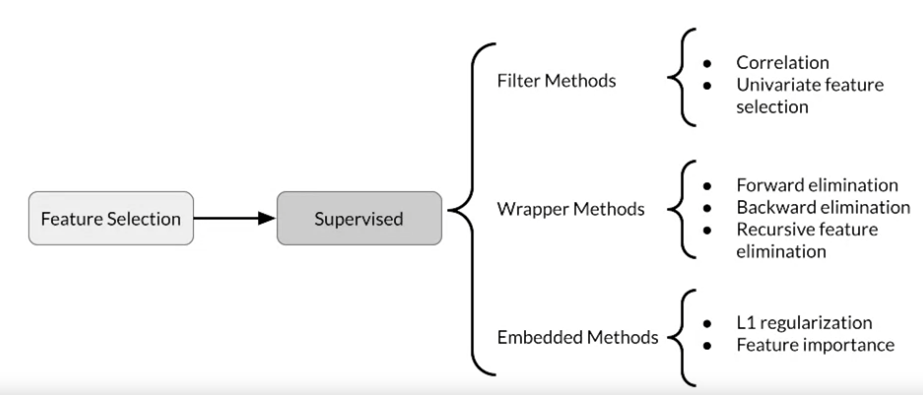

### Adding variables of $X$

Besides binning or adding higher-order terms discussed elsewhere in this notebook, another trick is to use unsupervised techniques and produce 'class centroids' as another feature; see more details in [Kmeans](../unsupervised_learning/Kmean.ipynb).

### Imputation of missing values

If possible, do a full Bayesian modeling for missing data, or just use [kNN](../supervised_learning/kNN.ipynb). Otherwise, rely on `fillna` in `pandas` or `SimpleImputer` in `sklearn`, detailed below.

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)
X = imputer.transform(housing_num)

Note that missing data should not be confused with **censored data** where the exact value is missing but something is known about its value.

Also note that some models can inherently deal with missing data, such as tree-based techniques.

### Generating polynomial features

Often it’s useful to add complexity to the model by considering nonlinear features of the input data. A simple and common method to use is polynomial features, which can get features’ high-order and interaction terms. This is another easy way to introduce non-linearity and interaction between $X$s.

For instance, the features of $X$ below has been transformed from $(X_1, X_2)$ to $(1, X_1, X_2, X_1^2, X_1X_2, X_2^2)$.

In [ ]:
poly = preprocessing.PolynomialFeatures(2)
X = np.arange(6).reshape(3, 2)
poly = PolynomialFeatures(2)

### Custom transformers

Often, you will want to convert an existing Python function into a transformer to assist in data cleaning or processing. You can implement a transformer from an arbitrary function with `FunctionTransformer`.

In [ ]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)

Or you can even write your own transformer class. Since `sklearn` relies on duck typing (not inheritance), all you need to do is create a class and implement three methods: `fit()` (returning self), `transform()`, and `fit_transform()`. 

You can get the last one for free by simply adding `TransformerMixin` as a base class. If you add
BaseEstimator as a base class (and avoid `*args` and `**kargs` in your constructor), you will
also get two extra methods (`get_params()` and `set_params()`) that will be useful for automatic
hyperparameter tuning.

In [ ]:
# Following example is from Chapter 2 of <Hands-on>

from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
            bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Pipelines and Composite Estimators

### `Pipelines`: chaining estimators

`Pipeline` can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. `Pipeline` serves multiple purposes here:
- **Convenience and encapsulation**. You only have to call fit and predict once on your data to fit a whole sequence of estimators.

- **Joint parameter selection**. You can grid search over parameters of all estimators in the pipeline at once.

- **Safety**. Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

The `Pipeline` is built using a list of `(key, value)` pairs, where the `key` is a string containing the name you want to give this step and `value` is an estimator object:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators, memory=cachedir)

The estimators of a pipeline are stored as a list in the `steps` attribute, but can be accessed by index or name by indexing (with `[idx]`) the `Pipeline`, which also supports slicing for extracting the sub-pipeline to perform some of the transforms.

In [ ]:
pipe.steps[0]
pipe[0]
pipe[:1]

Parameters of the estimators in the pipeline can be accessed using the `<estimator>__<parameter>` syntax. This is particularly important for doing grid searches.

Calling `fit` on the pipeline is the same as calling `fit` on each estimator in turn, `transform` the input and pass it on to the next step. The pipeline has all the methods that the last estimator in the pipeline has, i.e. if the last estimator is a classifier, the `Pipeline` can be used as a classifier. If the last estimator is a transformer, again, so is the pipeline. Note that there is one limitation of `Pipeline`: the `fit` method does not expect a `sample_weight` argument. [< Advances in Financial Machine Learning >](https://www.evernote.com/shard/s191/nl/21353936/49556302-bb13-4b64-9153-2ed8883dc48a?title=Advances_in_Financial_Machine_Learning.pdf) provides the following work-around:

In [1]:
class MyPipeline(Pipeline):
    def fit(self,X,y,sample_weight=None,**fit_params):
        if sample_weight is not None:
            fit_params[self.steps[-1][0]+'__sample_weight']=sample_weight
        return super(MyPipeline,self).fit(X,y,**fit_params)

IndentationError: expected an indented block (<ipython-input-1-74ca795c643a>, line 4)

With its `memory` parameter set, `Pipeline` will cache each transformer after calling `fit`. This feature is used to avoid computing the fit transformers within a pipeline if the parameters and input data are identical. A typical example is the case of a grid search in which the transformers can be fitted only once and reused for each configuration. But a side effect is that with caching enabled, it may become impossible to inspect the original instance.

### `FeatureUnion`: composite feature spaces

`FeatureUnion` combines several transformer objects into a new transformer that combines their output. A FeatureUnion takes a list of transformer objects. During fitting, each of these is fit to the data independently. The transformers are applied in parallel, and the feature matrices they output are concatenated side-by-side into a larger matrix.

`FeatureUnion` serves the same purposes as `Pipeline` - convenience and joint parameter estimation and validation.

`FeatureUnion` and `Pipeline` can be combined to create complex models.

A `FeatureUnion` has no way of checking whether two transformers might produce identical features. It only produces a union when the feature sets are disjoint, and making sure they are the caller’s responsibility.

In [ ]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
estimators = [('linear_pca', PCA()), ('kernel_pca', KernelPCA())]

Like pipelines, feature unions have a shorthand constructor called `make_union` that does not require explicit naming of the components.

Like Pipeline, individual steps may be replaced using `set_params`, and ignored by setting to `'drop'`.

In [ ]:
combined.set_params(kernel_pca='drop')

### `ColumnTransformer` for heterogeneous data

Many datasets contain features of different types, say text, floats, and dates, where each type of feature requires separate preprocessing or feature extraction steps. Often it is easiest to preprocess data before applying `sklearn` methods, for example using `pandas`. Processing your data before passing it to `sklearn` might be problematic for one of the following reasons:

- Incorporating statistics from test data into the preprocessors makes cross-validation scores unreliable (known as **data leakage**), for example in the case of scalers or imputing missing values, or just simply demeaning a column while some rows may be served as test data in the split later.

- You may want to include the parameters of the preprocessors in a parameter search.

The `ColumnTransformer` helps performing different transformations for different columns of the data. `ColumnTransformer` can be applied within a `Pipeline` that is safe from data leakage and that can be parametrized; on the other hand, a `Pipeline` can be specified to transform column(s) in `ColumnTransformer`. `ColumnTransformer` works on arrays, sparse matrices, and pandas `DataFrames`.

Instead of using a transformer, you can specify the string `'drop'` if you want the columns to be dropped, or you can specify `'passthrough'` if you want the columns to be left untouched. 

You can also make use of `FunctionTransformer` to define customized function for column transform.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
column_trans = ColumnTransformer(
     [('city_category', OneHotEncoder(dtype='int'),['city']),
      ('title_bow', CountVectorizer(), 'title')],
     remainder='drop')
column_trans.fit(X)

### Inconsistency in feature engineering between training and testing/serving

As repeated many times in this and other notes, such inconsistencies lead to distribution skew between training and testing/serving data, which in turn lead to model performance degrade.

In theory, it suffices to have the same feature engineering and preprocessing steps for both training and serving data. In practice, things can be much more complicated.
- **Training and serving code paths can be very different**. This is the case when the programming language and/or computational platform are different in training vs serving, e.g. you have `sklearn` and GPU and it is on a Linux machine when you are training, but you might only be able to serve on an IBM machine.
- Somewhat relating to the above point, there might be **different deployment scenarios**, such as mobile, server or web browser.
- Nuances arising from **preprocessing granularity**, i.e. whether a transform can be done on instance-level or full-pass.
    - **Instance-level transforms** can be done on each instance in isolation, e.g. clipping (if the thresholds do not depend on other samples), multiplying several features, feature expanding, etc.
    - **Full-pass transforms** are those that can only be done once you have seen the whole or some population, e.g. MinMaxScaler, standardization, discretization/bucketing.
  
  When you are doing batch learning in training, the above distinction does not matter; however, in serving the model, inference can be done, say, in an online manner, so it is something you should think about. 
  - For instance, one can always use the training mean and training standard deviation to standardize serving data, but then there is no guarantee that the transformed serving data is standardized as a result, since the serving data may have different mean and standard deviation.
  - By the way, one of the famous mistake which causes data leakage and impact cross-validation, is that we preprocess the data using quantities pertaining not just the training dataset. For instance, de-mean the whole dataset using the whole-data population mean, before splitting the data into training and test for cross validation; see the discussion in [cross-validation-and-backtesting](cross-validation-and-backtesting.ipynb).
  
`tensorflow_transform` seems a tool to help avoid all these pitfalls, as well as using `apache_beam` to distribute preprocessing, but you have not tried it out yet. You are probably more familiar with Apache spark and kafka (?)

## References
- `sklearn` 0.23.0 document, Sections [6.1](https://scikit-learn.org/stable/modules/compose.html), [6.3](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ < Hands-on Machine Learning >](https://www.evernote.com/shard/s191/nl/21353936/e4e0f85e-357a-444d-b1a0-ec9cabd008cb?title=Hands-On%20Machine%20Learning%20with%20Scikit-Learn,%20Keras,%20and%20Tensorflow,%202nd%20Edition), Chapter 2.
- [< Applied Predictive Modeling>](https://www.evernote.com/shard/s191/nl/21353936/c9fda431-d9ba-4c73-83aa-d6799f78a46c?title=Applied_Predictive_Modeling%EF%BC%88by_Max_Kuhn_Kjell_Johnson%EF%BC%89.pdf), Chapter 3.
- MLEDU, Lecture 12.
- [< Advances in Financial Machine Learning >](https://www.evernote.com/shard/s191/nl/21353936/49556302-bb13-4b64-9153-2ed8883dc48a?title=Advances_in_Financial_Machine_Learning.pdf), Chapter 9.
- [Machine Learning Data Lifecycle in Production: feature engineering techniques](https://www.coursera.org/learn/machine-learning-data-lifecycle-in-production/lecture/l8Vjv/feature-engineering-techniques)
- [Machine Learning Data Lifecycle in Production: preprocessing data at scale](https://www.coursera.org/learn/machine-learning-data-lifecycle-in-production/lecture/EPAU8/preprocessing-data-at-scale)